In [1]:

from sklearn import datasets
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm   
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import kagglehub
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:

#download dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

#load CSV into a pandas dataframe
dataset = pd.read_csv(f"{path}/dataset.csv")

#see the first rows
#print(dataset.head())
#print(dataset.shape)

# see the features available
print(list(dataset.columns)) 
#print(dataset.iloc[5])


['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [3]:

#remove duplicates, speech-like tracks and rows with missing entries
dataset = dataset.drop_duplicates(subset=["track_name", "artists"], keep="first")
dataset = dataset[dataset['speechiness'] <= 0.66]
dataset = dataset.dropna() 

#number of unique genres after pre-processing
#num_genres = dataset['track_genre'].nunique()


In [4]:

#select relevant features
selected_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'acousticness', 'instrumentalness', 'valence', 'tempo'
]

#subset the dataset
X = dataset[selected_features].values
y = dataset['track_genre'].values

#create labels for the genres
le = LabelEncoder()
y_id = le.fit_transform(y)
num_genres = len(le.classes_)


In [5]:

#split proportions
test_size = 0.15
val_size = 0.15

#split into train (.7) and temp (.3)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_id, test_size=(test_size + val_size), random_state=42,
)

#split temp into validation (.15) and test (.15)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_size / (test_size + val_size)), random_state=42,
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))



Train: 56337
Validation: 12072
Test: 12073


In [6]:

scaler=StandardScaler()
X_train[:, [2, 3, 8]] = scaler.fit_transform(X_train[:, [2, 3, 8]])
X_val[:, [2, 3, 8]]   = scaler.transform(X_val[:, [2, 3, 8]])
X_test[:, [2, 3, 8]]  = scaler.transform(X_test[:, [2, 3, 8]])

#print(X_train)


In [7]:

#hyperparameters
embedding_dim = 10     #inicialmente 30, reduzimos para 10
num_epochs = 10        #a partir de 7 epochs, loss < 1%
learning_rate = 0.001  #se calhar diminuir para nao perder informação na rede
dropout = 0.2
batch_size = 64

#data conversion to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.long)

#create dataset and loader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [8]:

#genre encoder (y -> z)
class GenreEncoder(nn.Module):
    def __init__(self, num_genres, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_genres, embedding_dim)

    def forward(self, genre_id):
        if genre_id.dim() == 2 and genre_id.size(1) == 1:
            genre_id = genre_id.squeeze(1)
        z = self.embedding(genre_id)  # [batch, embedding_dim]
        return z

#feature encoder (x -> ẑ)
class FeatureEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, dropout_prob = 0.3):
        super().__init__()
        self.input = nn.Linear (input_dim, 64)
        self.hidden1 = nn.Linear (64, 64)
        self.hidden2 = nn.Linear (64, 64)
        self.out = nn.Linear (64, embedding_dim)
        self.dropout = nn.Dropout (p = dropout_prob)


    def forward(self, x):
        x = F.relu (self.input(x)); x = self.dropout(x)

        x = F.relu (self.hidden1(x)); x = self.dropout(x)

        x = F.relu (self.hidden2(x)); x = self.dropout(x)

        z_hat = self.out(x)
        return z_hat


In [9]:

genre_embedding = GenreEncoder(num_genres, embedding_dim)

model = FeatureEncoder(
    input_dim = X_train.shape[1], 
    embedding_dim = embedding_dim, dropout_prob = dropout
)

#loss
criterion = nn.CosineSimilarity(dim=1)

#optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(genre_embedding.parameters()),
    lr = learning_rate
)


In [10]:

for epoch in range(num_epochs):
    model.train()
    genre_embedding.train()

    total_loss = 0.0

    for x_feat, y_genre in train_dataloader:
        optimizer.zero_grad()
        
        z = genre_embedding(y_genre)
        
        z_hat = model(x_feat)

        cos_sim = criterion( z_hat, z)
        loss = 1 - cos_sim.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    

Epoch 1/10 | Loss: 0.7064
Epoch 2/10 | Loss: 0.3551
Epoch 3/10 | Loss: 0.1552
Epoch 4/10 | Loss: 0.0624
Epoch 5/10 | Loss: 0.0227
Epoch 6/10 | Loss: 0.0073
Epoch 7/10 | Loss: 0.0022
Epoch 8/10 | Loss: 0.0009
Epoch 9/10 | Loss: 0.0005
Epoch 10/10 | Loss: 0.0003


C:\Users\marta\AppData\Local\Temp\ipykernel_31968\3629317422.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', K)


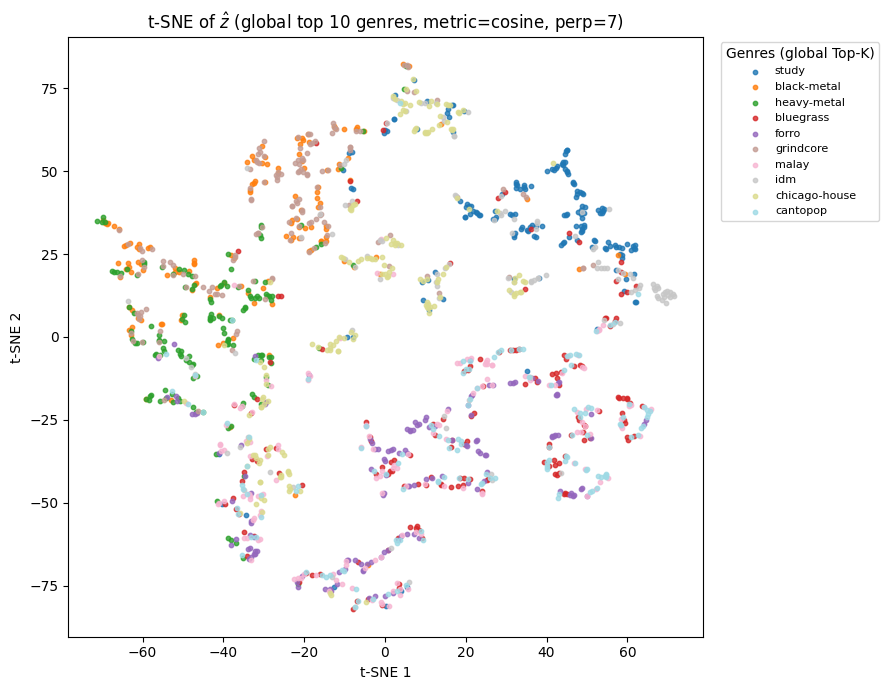

In [11]:

#visualizar os K generos mais frequentes

model.eval(); genre_embedding.eval()

with torch.no_grad():
    Zhat_val = model(X_val).cpu().numpy()
    y_val_np = y_val.cpu().numpy()

#top-K genres
K = 10
counts_all = pd.Series(y_id).value_counts()
topK_ids = counts_all.index[:K].to_numpy()
topK_names = le.inverse_transform(topK_ids)

# filter validation to those K
mask = np.isin(y_val_np, topK_ids)
Z = Zhat_val[mask]
y_small = y_val_np[mask]

# subsample for speed if needed
rng = np.random.RandomState(42)
max_points = 4000
if len(Z) > max_points:
    id = rng.choice(len(Z), size=max_points, replace=False)
    Z = Z[id]; y_small = y_small[id]

# normalize (cosine), PCA -> t-SNE
Zn = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)
pca = PCA(n_components=min(50, Z.shape[1]), random_state=42)
Zp = pca.fit_transform(Zn)

perp = min(50, max(5, len(Zp)//200))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate='auto',
            init='pca', metric='cosine', random_state=42)
Z2 = tsne.fit_transform(Zp)

#plot

cmap = cm.get_cmap('tab20', K)

plt.figure(figsize=(9,7))
for i, gid in enumerate(topK_ids):
    m = (y_small == gid)
    plt.scatter(Z2[m,0], Z2[m,1], s=10, color=cmap(i), alpha=0.8, label=topK_names[i])
plt.legend(title="Genres (global Top-K)", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.title(f"t-SNE of $\\hat{{z}}$ (global top {K} genres, metric=cosine, perp={perp})")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout(); plt.show()

Genres selected for visualization:
['pop', 'indie-pop', 'rock', 'metal', 'hip-hop', 'jazz', 'electronic', 'classical', 'country', 'reggae']


C:\Users\marta\AppData\Local\Temp\ipykernel_31968\545116620.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(existing))


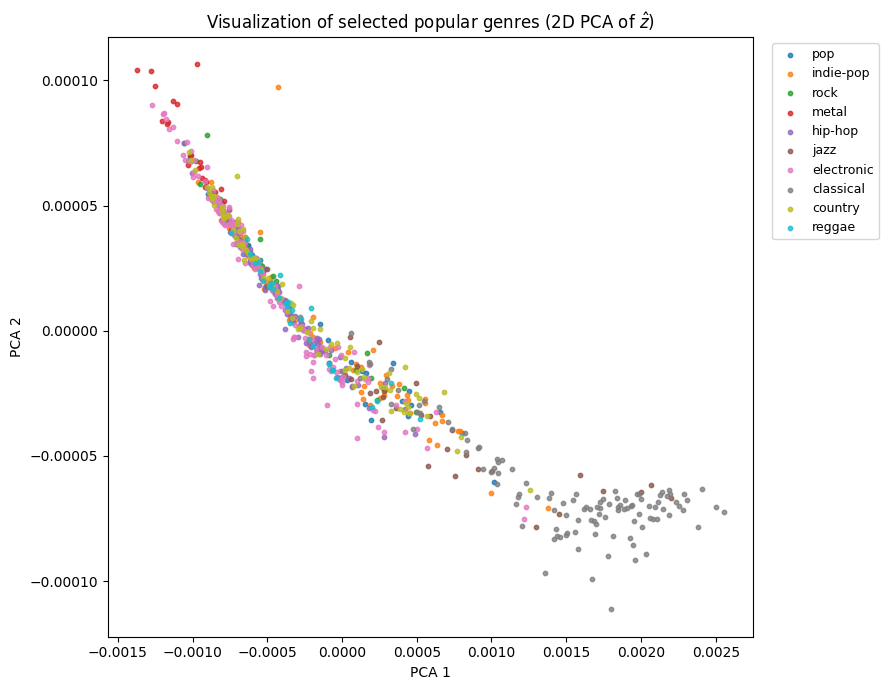

In [12]:
# 10 interpretable genres for visualization WITH PCA!!!!

selected_genres = [
    'pop', 'indie-pop', 'rock', 'metal', 'hip-hop',
    'jazz', 'electronic', 'classical', 'country', 'reggae'
]

# Find their encoded IDs (skip ones not in the dataset)
existing = [g for g in selected_genres if g in le.classes_]
selected_ids = le.transform(existing)

print("Genres selected for visualization:")
print(existing)

# Mask the validation set to include only these genres
mask = np.isin(y_val.cpu().numpy(), selected_ids)
Z = model(X_val[mask]).detach().cpu().numpy()
y_small = y_val.cpu().numpy()[mask]

# L2-normalize embeddings (for cosine geometry)
Z_norm = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)

# PCA → 2D projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z_norm)

# Plot
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure(figsize=(9,7))
cmap = cm.get_cmap('tab10', len(existing))

for i, gid in enumerate(selected_ids):
    m = (y_small == gid)
    plt.scatter(Z2[m,0], Z2[m,1], s=10, color=cmap(i), alpha=0.8, label=existing[i])

plt.title("Visualization of selected popular genres (2D PCA of $\hat{z}$)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


Genres selected for visualization:
['pop', 'indie-pop', 'rock', 'metal', 'hip-hop', 'jazz', 'electronic', 'classical', 'country', 'reggae']


C:\Users\marta\AppData\Local\Temp\ipykernel_31968\1116787462.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(existing))


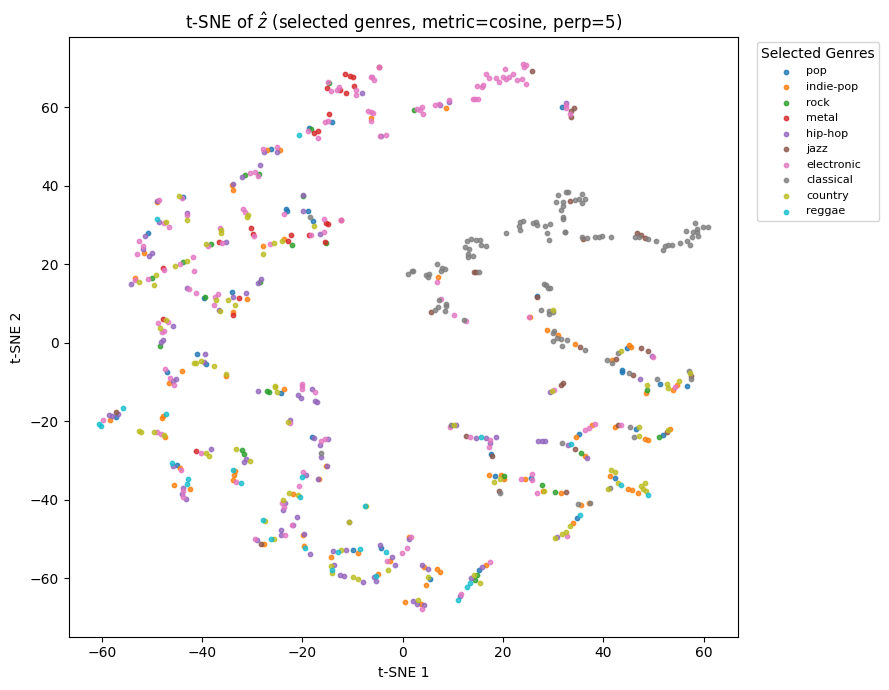

In [13]:
# Compute the embeddings (Zhat_val) and corresponding labels (y_val_np)
with torch.no_grad():
    Zhat_val = model(X_val).cpu().numpy()
    y_val_np = y_val.cpu().numpy()

# Define the genres you want to visualize
selected_genres = [
    'pop', 'indie-pop', 'rock', 'metal', 'hip-hop',
    'jazz', 'electronic', 'classical', 'country', 'reggae'
]

# Keep only genres that exist in the dataset and get their encoded IDs
existing = [g for g in selected_genres if g in le.classes_]
selected_ids = le.transform(existing)

print("Genres selected for visualization:")
print(existing)

# Filter the validation data to include only the selected genres
mask = np.isin(y_val_np, selected_ids)
Z = Zhat_val[mask]
y_small = y_val_np[mask]

# Optionally subsample points for faster visualization (keeps up to 4000)
rng = np.random.RandomState(42)
max_points = 4000
if len(Z) > max_points:
    idx = rng.choice(len(Z), size=max_points, replace=False)
    Z = Z[idx]
    y_small = y_small[idx]

# Normalize embeddings (unit vectors) to use cosine distance correctly
Zn = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)

# Apply PCA for dimensionality reduction before t-SNE (helps speed and stability)
pca = PCA(n_components=min(50, Z.shape[1]), random_state=42)
Zp = pca.fit_transform(Zn)

# Define t-SNE perplexity dynamically based on data size
perp = min(50, max(5, len(Zp)//200))

# Run t-SNE to project embeddings into 2D space for visualization
tsne = TSNE(
    n_components=2, perplexity=perp, learning_rate='auto',
    init='pca', metric='cosine', random_state=42
)
Z2 = tsne.fit_transform(Zp)

# Plot the 2D t-SNE map with colors for each selected genre
cmap = cm.get_cmap('tab10', len(existing))
plt.figure(figsize=(9,7))
for i, gid in enumerate(selected_ids):
    m = (y_small == gid)
    plt.scatter(Z2[m,0], Z2[m,1], s=10, color=cmap(i), alpha=0.8, label=existing[i])

plt.legend(title="Selected Genres", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.title(f"t-SNE of $\\hat{{z}}$ (selected genres, metric=cosine, perp={perp})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [14]:
#fuzzy c-means clustering - sem visualização

# ---- Extract genre embeddings after training ----
genre_embedding.eval()
Zgenres = genre_embedding.embedding.weight.detach().cpu().numpy()   # [num_genres, embedding_dim]

# ---- Normalize (cosine geometry) ----
Zg = Zgenres / (np.linalg.norm(Zgenres, axis=1, keepdims=True) + 1e-12)

# ---- Fuzzy C-Means clustering ----
c = 8       # number of broad clusters
m = 2.0      # fuzziness parameter
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Zg.T, c=c, m=m, error=1e-6, maxiter=1000, init=None, seed=42
)
print(f"Fuzzy partition coefficient (FPC): {fpc:.3f}")

# ---- Hard cluster assignment + confidence ----
labels_hard = u.argmax(axis=0)    # cluster index for each genre
labels_conf = u.max(axis=0)       # highest membership value (confidence)

# ---- Build table: micro-genre -> cluster info ----
genre_names_all = le.classes_
df_clusters = pd.DataFrame({
    "genre": genre_names_all,
    "cluster": labels_hard,
    "membership": labels_conf
}).sort_values(["cluster", "membership"], ascending=[True, False]).reset_index(drop=True)

print("\nTop rows of fuzzy cluster mapping:")
print(df_clusters.head(110))

# ---- Map every song's genre ID to its cluster ID ----
cluster_of_genre = labels_hard
y_train_cluster = cluster_of_genre[y_train.cpu().numpy()]
y_val_cluster   = cluster_of_genre[y_val.cpu().numpy()]
y_test_cluster  = cluster_of_genre[y_test]

print(df_clusters['cluster'].value_counts().sort_index())


Fuzzy partition coefficient (FPC): 0.431

Top rows of fuzzy cluster mapping:
         genre  cluster  membership
0         jazz        0    1.000000
1         rock        1    1.000000
2        piano        2    0.803011
3    indie-pop        2    0.727751
4      hip-hop        2    0.694991
..         ...      ...         ...
105    electro        7    0.402475
106     techno        7    0.398719
107      samba        7    0.390537
108   acoustic        7    0.384550
109     trance        7    0.384290

[110 rows x 3 columns]
cluster
0     1
1     1
2    17
3     1
4    32
5    25
6     1
7    35
Name: count, dtype: int64


C:\Users\marta\AppData\Local\Temp\ipykernel_31968\1998990321.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', c)


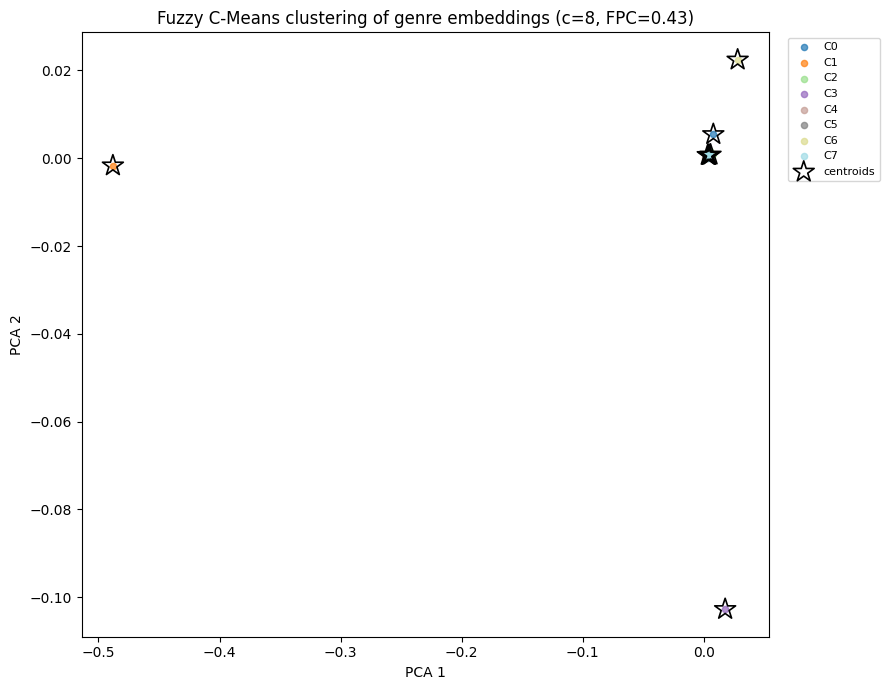

In [15]:
#%% Visualization of fuzzy clusters

# Project the genre embeddings (Zg) to 2D with PCA
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Zg)          # shape [num_genres, 2]
C2 = pca.transform(cntr)            # cluster centers [c, 2]

plt.figure(figsize=(9,7))
cmap = plt.cm.get_cmap('tab20', c)

# Plot each genre embedding colored by its hard cluster
for k in range(c):
    m = (labels_hard == k)
    plt.scatter(Z2[m,0], Z2[m,1], s=20, color=cmap(k), alpha=0.7, label=f"C{k}")

# Plot cluster centroids
plt.scatter(C2[:,0], C2[:,1], s=250, marker='*', edgecolor='k', facecolor='none', linewidths=1.2, label='centroids')

plt.title(f"Fuzzy C-Means clustering of genre embeddings (c={c}, FPC={fpc:.2f})")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


In [17]:
# ---- Prepare inputs ----
# X_train, X_val, X_test already exist (scaled tensors)
# You must now have y_train_clusters, y_val_clusters, y_test_clusters
# containing the fuzzy cluster labels (ints 0..K-1)

# Convert to tensors
y_train_cluster = torch.tensor(y_train_cluster, dtype=torch.long)
y_val_cluster = torch.tensor(y_val_cluster, dtype=torch.long)
y_test_cluster = torch.tensor(y_test_cluster, dtype=torch.long)

train_dataset_cls = TensorDataset(X_train, y_train_cluster)
val_dataset_cls = TensorDataset(X_val, y_val_cluster)
test_dataset_cls = TensorDataset(X_test, y_test_cluster)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=64, shuffle=True)
val_loader_cls   = DataLoader(val_dataset_cls, batch_size=64)
test_loader_cls  = DataLoader(test_dataset_cls, batch_size=64)

# ---- Define the MLP model ----
class GenreClusterClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, num_clusters=K, dropout_prob=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_clusters)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

# ---- Initialize model ----
K = len(np.unique(y_train_clusters))  # number of fuzzy clusters
clf_model = GenreClusterClassifier(input_dim=X_train.shape[1], num_clusters=K)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=1e-3)

# ---- Training loop ----
num_epochs = 30
for epoch in range(num_epochs):
    clf_model.train()
    total_loss = 0.0
    for xb, yb in train_loader_cls:
        optimizer.zero_grad()
        preds = clf_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_cls)

    # Validation accuracy
    clf_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            preds = clf_model(xb)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f}  |  Val Acc: {val_acc:.2f}%")

# ---- Final test evaluation ----
clf_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader_cls:
        preds = clf_model(xb)
        _, predicted = torch.max(preds, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

TypeError: 'int' object is not callable